## Imports

In [1]:
import os
import cv2 as cv
import json
import matplotlib
import matplotlib.pyplot as plt
import glob
import pandas as pd
import random
from tqdm import tqdm

from torchvision.transforms import v2
import torch
from torch.utils.data import DataLoader

#Ignore user warnings
import warnings
warnings.filterwarnings("ignore")

## Checking Annotations

In [2]:
# Read a JSON file
with open('data/Annotations/train.json') as f:
    trainJSON = json.load(f)

with open('data/Annotations/val.json') as f:
    valJSON = json.load(f)

with open('data/Annotations/test.json') as f:
    testJSON = json.load(f)

In [3]:
classes = trainJSON['categories']

train_images = trainJSON['images']
val_images = valJSON['images']
test_images = testJSON['images']

train_annotations = trainJSON['annotations']
val_annotations = valJSON['annotations']
test_annotations = testJSON['annotations']

In [4]:
print('========= Classes =========')
display(classes)
print('========= Train images =========')
display(train_images[:2])
print('========= Train nnotations =========')
display(train_annotations[:2])

========= Classes =========


[{'id': 1, 'name': 'LE;ER', 'supercategory': None},
 {'id': 4, 'name': 'SF;PO', 'supercategory': None},
 {'id': 0, 'name': 'VG;MT', 'supercategory': None},
 {'id': 2, 'name': 'LR;DA', 'supercategory': None},
 {'id': 3, 'name': 'LE;CR', 'supercategory': None}]

========= Train images =========


[{'id': 0,
  'folder': '/content/drive/MyDrive/AVALON/DTU-S2-and-S3/DTU-S3/S3-HR-train70-test15-val15-split/HR-dataset-split/Data-preparation/train-data/1024-s/train-images/',
  'file_name': 'DJI_0058_1_3.JPG',
  'path': None,
  'width': 1024,
  'height': 1024,
  'depth': 3},
 {'id': 1,
  'folder': '/content/drive/MyDrive/AVALON/DTU-S2-and-S3/DTU-S3/S3-HR-train70-test15-val15-split/HR-dataset-split/Data-preparation/train-data/1024-s/train-images/',
  'file_name': 'DJI_0013_0_3.JPG',
  'path': None,
  'width': 1024,
  'height': 1024,
  'depth': 3}]

========= Train nnotations =========


[{'image_id': 0,
  'id': 0,
  'segmented': None,
  'bbox': [383.996928, 424.001024, 99.00032, 90.000384],
  'area': 8910.0668161229,
  'segmentation': None,
  'iscrowd': 0,
  'pose': None,
  'truncated': None,
  'category_id': 1,
  'difficult': None},
 {'image_id': 0,
  'id': 1,
  'segmented': None,
  'bbox': [616.001024, 20.00128, 45.999104, 47.000576],
  'area': 2161.9843834839,
  'segmentation': None,
  'iscrowd': 0,
  'pose': None,
  'truncated': None,
  'category_id': 4,
  'difficult': None}]

In [5]:
train_images_names = []
val_images_names = []
test_images_names = []

for metadata in train_images:
    img_name = metadata['file_name'][:8] + metadata['file_name'][-4:]
    train_images_names.append(img_name)

for metadata in val_images:
    img_name = metadata['file_name'][:8] + metadata['file_name'][-4:]
    val_images_names.append(img_name)

for metadata in test_images:
    img_name = metadata['file_name'][:8] + metadata['file_name'][-4:]
    test_images_names.append(img_name)

# Drop duplicates from the lists
train_images_names = list(set(train_images_names))
val_images_names = list(set(val_images_names))
test_images_names = list(set(test_images_names))

In [6]:
print('========= Train images names =========')
display(train_images_names[:11])
print('========= Validation images names =========')
display(val_images_names[:11])
print('========= Test images names =========')
display(test_images_names[:11])

========= Train images names =========


['DJI_0751.JPG',
 'DJI_0995.JPG',
 'DJI_0693.JPG',
 'DJI_0012.JPG',
 'DJI_0175.JPG',
 'DJI_0250.JPG',
 'DJI_0125.JPG',
 'DJI_0057.JPG',
 'DJI_0335.JPG',
 'DJI_0360.JPG',
 'DJI_0093.JPG']

========= Validation images names =========


['DJI_0329.JPG',
 'DJI_0712.JPG',
 'DJI_0033.JPG',
 'DJI_0048.JPG',
 'DJI_0110.JPG',
 'DJI_0708.JPG',
 'DJI_0059.JPG',
 'DJI_0430.JPG',
 'DJI_0119.JPG',
 'DJI_0185.JPG',
 'DJI_0238.JPG']

========= Test images names =========


['DJI_0038.JPG',
 'DJI_0026.JPG',
 'DJI_0201.JPG',
 'DJI_0174.JPG',
 'DJI_0021.JPG',
 'DJI_0112.JPG',
 'DJI_0624.JPG',
 'DJI_0616.JPG',
 'DJI_0710.JPG',
 'DJI_0433.JPG',
 'DJI_0395.JPG']

## Data Preparation

In [10]:
class NordtankDataset(torch.utils.data.Dataset):
    def __init__(self, images_names, transform = None):
        self.images_names = images_names
        self.transform = transform

    def __len__(self):
        return len(self.images_names)

    def __getitem__(self, idx):
        img_name = self.images_names[idx]
        img_path = img_name
        image = cv.imread(img_path)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        image = torch.from_numpy(image.transpose(2, 0, 1))

        if self.transform:
            image = self.transform(image)
    
        image = image.permute(1, 2, 0)

        return image


def DivideImage(image, sub_size, resize):
    sub_images = []
    sub_images_resized = []
    h, w, c = image.shape
    image_np = image.numpy()  # Convert PyTorch tensor to NumPy array
    for i in range(0, h, sub_size):
        for j in range(0, w, sub_size):
            sub_image = image_np[i:i+sub_size, j:j+sub_size]
            sub_images.append(sub_image)
            # Resize the sub-image to 100x100
            sub_image_resized = cv.resize(sub_image, (resize, resize))
            sub_images_resized.append(torch.tensor(sub_image_resized))

    # Get the indexes of the sub-images that are 1024x1024
    idx = []
    for i, sub_image in enumerate(sub_images):
        if sub_image.shape == (sub_size, sub_size, c):
            idx.append(i)

    # Filter sub_images_resized by the indexes
    sub_images_resized = [sub_images_resized[i] for i in idx]

    return sub_images_resized


# Plot test image with red squares showing the sub-images
def PlotDividedImage(image, size, resize):
    # image: a PyTorch tensor with shape (H, W, C)
    # size: the size of the sub-images (size x size)
    H, W, C = image.shape
    sub_images = DivideImage(image, size, resize)
    fig, ax = plt.subplots()
    ax.imshow(image)
    for i in range(0, H, size):
        for j in range(0, W, size):
            rect = matplotlib.patches.Rectangle((j, i), size, size, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
    plt.show()


# Plot the bounding box of the annotation in an image
def PlotBoundingBox(image, bbox):
    # image: a PyTorch tensor with shape (H, W, C)
    # bbox: a dictionary with the annotation of the image
    fig, ax = plt.subplots()
    ax.imshow(image)
    x, y, w, h = bbox
    rect = matplotlib.patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.show()

# Plot the center point of the bounding box
def PlotCenterPoint(image, bbox):
    # image: a PyTorch tensor with shape (H, W, C)
    # bbox: a dictionary with the annotation of the image
    fig, ax = plt.subplots()
    ax.imshow(image)
    center_x, center_y = bbox
    ax.scatter(center_x, center_y, c='r', s=10)
    plt.show()


def CreateDatasetSubImages(dataset, dataframe, train_image_path_lst, sub_size, resize):
    sub_images = []
    sub_labels = []
    centerpoints = []
    bboxes = []

    for image_name in dataframe['file_name'].unique():
        sub_images_df = dataframe[dataframe['file_name'] == image_name]
        sub_image_labels = [-1] * 10
        cpoints_sub_image = [None] * 10
        bboxes_sub_image = [None] * 10


        idx = train_image_path_lst.index('data/Images/' + image_name)
        image = dataset[idx]
        for index, sub_image in sub_images_df.iterrows():
            row = int(sub_image['sub_image_row'])
            col = int(sub_image['sub_image_col'])
            sub_image_labels[(row * 5) + col] = int(sub_image['category_id'])
            center_x = sub_image['bbox'][0] + sub_image['bbox'][2] / 2
            center_y = sub_image['bbox'][1] + sub_image['bbox'][3] / 2
            cpoints_sub_image[(row * 5) + col] = (center_x, center_y)
            bboxes_sub_image[(row * 5) + col] = sub_image['bbox']

        sub_images += DivideImage(image, sub_size, resize)
        sub_labels += sub_image_labels
        centerpoints += cpoints_sub_image
        bboxes += bboxes_sub_image

    factor = resize / sub_size

    # multiply the bbox values by 0.25 if the value in not None
    centerpoints = [tuple(factor * x for x in bbox) if bbox is not None else None for bbox in centerpoints]
    bboxes = [tuple(factor * x for x in bbox) if bbox is not None else None for bbox in bboxes]
        
    return sub_images, sub_labels, centerpoints, bboxes


# Define a function that duplicates the images from a list with random sampling until a certain number of images is reached
def DuplicateImages(image_lst, target_size):
    initial_size = len(image_lst)
    current_size = len(image_lst)
    image_lst_copy = image_lst.copy()

    while current_size < target_size - initial_size:
        random_element = random.choice(image_lst)
        image_lst_copy.append(random_element)
        current_size += 1

    return image_lst_copy


def GetSubImagesByLabel(sub_images, sub_labels):

    idx_neg1 = []
    idx_zero = []
    idx_one = []
    idx_two = []
    idx_three = []
    idx_four = []

    for idx, label in enumerate(sub_labels):
        if label == -1:
            idx_neg1.append(idx)
        elif label == 0:
            idx_zero.append(idx)
        elif label == 1:
            idx_one.append(idx)
        elif label == 2:
            idx_two.append(idx)
        elif label == 3:
            idx_three.append(idx)
        else:
            idx_four.append(idx)


    sub_images_neg1 = [sub_images[idx] for idx in idx_neg1]
    sub_images_zero = [sub_images[idx] for idx in idx_zero]
    sub_images_one = [sub_images[idx] for idx in idx_one]
    sub_images_two = [sub_images[idx] for idx in idx_two]
    sub_images_three = [sub_images[idx] for idx in idx_three]
    sub_images_four = [sub_images[idx] for idx in idx_four]

    return sub_images_neg1, sub_images_zero, sub_images_one, sub_images_two, sub_images_three, sub_images_four


def IntegrateImagesAnnotations(images, annotations):

    images_df = pd.DataFrame(images)
    annotations_df = pd.DataFrame(annotations)

    images_df.drop(columns = ['folder', 'path', 'width', 'height', 'depth'], inplace = True)
    annotations_df.drop(columns = ['segmented', 'area', 'segmentation', 'iscrowd', 'pose', 'truncated', 'difficult'], inplace = True)

    # Create two new columns in train_images_df that contain the row and column of the sub-image with the annotation
    images_df['sub_image_row'] = images_df['file_name'].str[9:10].astype(int)
    images_df['sub_image_col'] = images_df['file_name'].str[11:12].astype(int)
    images_df['file_name'] = images_df['file_name'].str[:8] + images_df['file_name'].str[-4:]

    #Change the name of the column "id" to "image_id" in the train_images_df
    images_df.rename(columns = {'id': 'image_id'}, inplace = True)

    # Merge train_images_df and train_annotations_df using the key "image_id"
    df = pd.merge(images_df, annotations_df, on = 'image_id').drop(columns = ['id'])

    # Delete all rows that have duplicate values in the columns "image_id", "sub_image_row", and "sub_image_col"
    df.drop_duplicates(subset = ['image_id', 'sub_image_row', 'sub_image_col'], keep = False, inplace = True)

    return df

In [11]:
train_df = IntegrateImagesAnnotations(train_images, train_annotations)
val_df = IntegrateImagesAnnotations(val_images, val_annotations)
test_df = IntegrateImagesAnnotations(test_images, test_annotations)

In [12]:
# Obter todos os caminhos das imagens no diretório 'data/Images'
images = glob.glob('data/Images/*.JPG')

# Inicializar listas de caminhos para treino, validação e teste
train_images_paths = []
val_images_paths = []
test_images_paths = []

# Iterar sobre todas as imagens e adicionar aos respectivos conjuntos
for img in images:
    img_name = os.path.basename(img)  # Obter o nome do arquivo da imagem

    if img_name in train_images_names:
        train_images_paths.append(img.replace("\\", "/"))

    elif img_name in val_images_names:
        val_images_paths.append(img.replace("\\", "/"))

    elif img_name in test_images_names:
        test_images_paths.append(img.replace("\\", "/"))

# Imprimir os caminhos corrigidos
print(train_images_paths)
print(val_images_paths)
print(test_images_paths)

['data/Images/DJI_0004.JPG', 'data/Images/DJI_0005.JPG', 'data/Images/DJI_0007.JPG', 'data/Images/DJI_0008.JPG', 'data/Images/DJI_0009.JPG', 'data/Images/DJI_0010.JPG', 'data/Images/DJI_0011.JPG', 'data/Images/DJI_0012.JPG', 'data/Images/DJI_0013.JPG', 'data/Images/DJI_0014.JPG', 'data/Images/DJI_0016.JPG', 'data/Images/DJI_0017.JPG', 'data/Images/DJI_0018.JPG', 'data/Images/DJI_0019.JPG', 'data/Images/DJI_0020.JPG', 'data/Images/DJI_0022.JPG', 'data/Images/DJI_0023.JPG', 'data/Images/DJI_0024.JPG', 'data/Images/DJI_0025.JPG', 'data/Images/DJI_0027.JPG', 'data/Images/DJI_0028.JPG', 'data/Images/DJI_0030.JPG', 'data/Images/DJI_0031.JPG', 'data/Images/DJI_0032.JPG', 'data/Images/DJI_0034.JPG', 'data/Images/DJI_0035.JPG', 'data/Images/DJI_0037.JPG', 'data/Images/DJI_0044.JPG', 'data/Images/DJI_0046.JPG', 'data/Images/DJI_0049.JPG', 'data/Images/DJI_0050.JPG', 'data/Images/DJI_0051.JPG', 'data/Images/DJI_0052.JPG', 'data/Images/DJI_0056.JPG', 'data/Images/DJI_0057.JPG', 'data/Images/DJI_00

In [13]:
TrainOriginalDataset = NordtankDataset(train_images_paths)
ValOriginalDataset = NordtankDataset(val_images_paths)
TestOriginalDataset = NordtankDataset(test_images_paths)

train_sub_images, train_sub_labels, train_centerpoints, train_bboxes = CreateDatasetSubImages(TrainOriginalDataset, train_df, train_images_paths, 1024, 128)
val_sub_images, val_sub_labels, val_centerpoints, val_bboxes = CreateDatasetSubImages(ValOriginalDataset, val_df, val_images_paths, 1024, 128)
test_sub_images, test_sub_labels, test_centerpoints, test_bboxes = CreateDatasetSubImages(TestOriginalDataset, test_df, test_images_paths, 1024, 128)

# Normalize all images in train_sub_images by dividing by 255
train_sub_images = [image / 255 for image in train_sub_images]
val_sub_images = [image / 255 for image in val_sub_images]
test_sub_images = [image / 255 for image in test_sub_images]

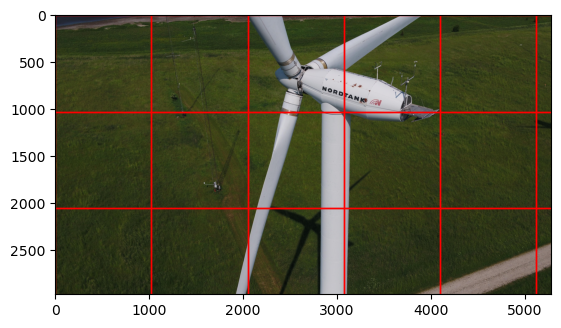

In [14]:
PlotDividedImage(TrainOriginalDataset[0], 1024, 128)

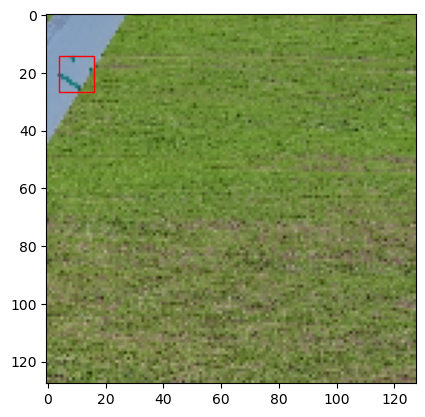

In [15]:
PlotBoundingBox(train_sub_images[1013], train_bboxes[1013])

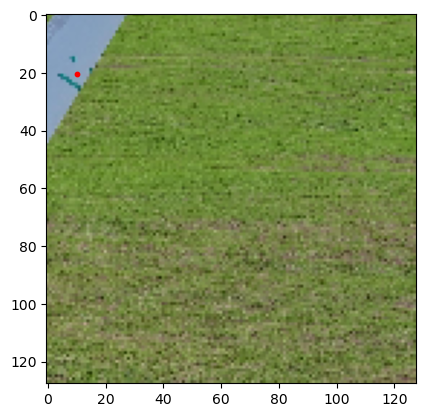

In [16]:
PlotCenterPoint(train_sub_images[1013], train_centerpoints[1013])

In [17]:
def GetAnnotationsByLabel(sub_images, labels, centerpoints, bboxes, target_label):
    sub_images_category = []
    centerpoints_category = []
    bboxes_category = []

    for i in range(len(labels)):
        if labels[i] == target_label:
            sub_images_category.append(sub_images[i])
            centerpoints_category.append(centerpoints[i])
            bboxes_category.append(bboxes[i])

    return sub_images_category, centerpoints_category, bboxes_category

def DuplicateCategoryData(images, centerpoints, bboxes, target_size):
    initial_size = len(images)
    current_size = len(images)
    images_copy = images.copy()
    centerpoints_copy = centerpoints.copy()
    bboxes_copy = bboxes.copy()

    while current_size < target_size - initial_size:
        random_index = random.randint(0, initial_size - 1)
        duplicated_image = images[random_index]
        images_copy.append(duplicated_image)
        centerpoints_copy.append(centerpoints[random_index])
        bboxes_copy.append(bboxes[random_index])
       
        current_size += 1

    return images_copy, centerpoints_copy, bboxes_copy


In [18]:
# Train
train_sub_images_neg1, train_centerpoints_neg1, train_bboxes_neg1 = GetAnnotationsByLabel(train_sub_images, train_sub_labels, train_centerpoints, train_bboxes, -1)
train_sub_images_zero, train_centerpoints_zero, train_bboxes_zero = GetAnnotationsByLabel(train_sub_images, train_sub_labels, train_centerpoints, train_bboxes, 0)
train_sub_images_one, train_centerpoints_one, train_bboxes_one = GetAnnotationsByLabel(train_sub_images, train_sub_labels, train_centerpoints, train_bboxes, 1)
train_sub_images_two, train_centerpoints_two, train_bboxes_two = GetAnnotationsByLabel(train_sub_images, train_sub_labels, train_centerpoints, train_bboxes, 2)
train_sub_images_three, train_centerpoints_three, train_bboxes_three = GetAnnotationsByLabel(train_sub_images, train_sub_labels, train_centerpoints, train_bboxes, 3)
train_sub_images_four, train_centerpoints_four, train_bboxes_four = GetAnnotationsByLabel(train_sub_images, train_sub_labels, train_centerpoints, train_bboxes, 4)

# Test
val_sub_images_neg1, val_centerpoints_neg1, val_bboxes_neg1 = GetAnnotationsByLabel(val_sub_images, val_sub_labels, val_centerpoints, val_bboxes, -1)
val_sub_images_zero, val_centerpoints_zero, val_bboxes_zero = GetAnnotationsByLabel(val_sub_images, val_sub_labels, val_centerpoints, val_bboxes, 0)
val_sub_images_one, val_centerpoints_one, val_bboxes_one = GetAnnotationsByLabel(val_sub_images, val_sub_labels, val_centerpoints, val_bboxes, 1)
val_sub_images_two, val_centerpoints_two, val_bboxes_two = GetAnnotationsByLabel(val_sub_images, val_sub_labels, val_centerpoints, val_bboxes, 2)
val_sub_images_three, val_centerpoints_three, val_bboxes_three = GetAnnotationsByLabel(val_sub_images, val_sub_labels, val_centerpoints, val_bboxes, 3)
val_sub_images_four, val_centerpoints_four, val_bboxes_four = GetAnnotationsByLabel(val_sub_images, val_sub_labels, val_centerpoints, val_bboxes, 4)

# Val
test_sub_images_neg1, test_centerpoints_neg1, test_bboxes_neg1 = GetAnnotationsByLabel(test_sub_images, test_sub_labels, test_centerpoints, test_bboxes, -1)
test_sub_images_zero, test_centerpoints_zero, test_bboxes_zero = GetAnnotationsByLabel(test_sub_images, test_sub_labels, test_centerpoints, test_bboxes, 0)
test_sub_images_one, test_centerpoints_one, test_bboxes_one = GetAnnotationsByLabel(test_sub_images, test_sub_labels, test_centerpoints, test_bboxes, 1)
test_sub_images_two, test_centerpoints_two, test_bboxes_two = GetAnnotationsByLabel(test_sub_images, test_sub_labels, test_centerpoints, test_bboxes, 2)
test_sub_images_three, test_centerpoints_three, test_bboxes_three = GetAnnotationsByLabel(test_sub_images, test_sub_labels, test_centerpoints, test_bboxes, 3)
test_sub_images_four, test_centerpoints_four, test_bboxes_four = GetAnnotationsByLabel(test_sub_images, test_sub_labels, test_centerpoints, test_bboxes, 4)

sub_images_zero_dup, centerpoints_zero_dup, bboxes_zero_dup = DuplicateCategoryData(
    train_sub_images_zero, train_centerpoints_zero, train_bboxes_zero, 1529
)
sub_images_one_dup, centerpoints_one_dup, bboxes_one_dup = DuplicateCategoryData(
    train_sub_images_one, train_centerpoints_one, train_bboxes_one, 1529
)

sub_images_two_dup, centerpoints_two_dup, bboxes_two_dup = DuplicateCategoryData(
    train_sub_images_two, train_centerpoints_two, train_bboxes_two, 1529
)

sub_images_three_dup, centerpoints_three_dup, bboxes_three_dup= DuplicateCategoryData(
    train_sub_images_three, train_centerpoints_three, train_bboxes_three, 1529
)

sub_images_four_dup, centerpoints_four_dup, bboxes_four_dup = DuplicateCategoryData(
    train_sub_images_four, train_centerpoints_four, train_bboxes_four, 1529
)


dup_data_per_category = {
    'zero': {'images': sub_images_zero_dup, 'centerpoints': centerpoints_zero_dup, 'bboxes': bboxes_zero_dup, 'labels':0},
    'one': {'images': sub_images_one_dup, 'centerpoints': centerpoints_one_dup, 'bboxes': bboxes_one_dup, 'labels':1 },
    'two': {'images': sub_images_two_dup, 'centerpoints': centerpoints_two_dup, 'bboxes': bboxes_two_dup, 'labels':2},
    'three': {'images': sub_images_three_dup, 'centerpoints': centerpoints_three_dup, 'bboxes': bboxes_three_dup, 'labels':3},
    'four': {'images': sub_images_four_dup, 'centerpoints': centerpoints_four_dup, 'bboxes': bboxes_four_dup, 'labels':4},
}


train_data_per_category = {
    'neg1': {'images': train_sub_images_neg1, 'centerpoints': train_centerpoints_neg1, 'bboxes': train_bboxes_neg1, 'labels':-1},
    'zero': {'images': train_sub_images_zero, 'centerpoints': train_centerpoints_zero, 'bboxes': train_bboxes_zero, 'labels':0},
    'one': {'images': train_sub_images_one, 'centerpoints': train_centerpoints_one, 'bboxes': train_bboxes_one, 'labels':1},
    'two': {'images': train_sub_images_two, 'centerpoints': train_centerpoints_two, 'bboxes': train_bboxes_two, 'labels':2},
    'three': {'images': train_sub_images_three, 'centerpoints': train_centerpoints_three, 'bboxes': train_bboxes_three, 'labels':3},
    'four': {'images': train_sub_images_four, 'centerpoints': train_centerpoints_four, 'bboxes': train_bboxes_four, 'labels':4},
}

val_data_per_category = {
    'neg1': {'images': val_sub_images_neg1, 'centerpoints': val_centerpoints_neg1, 'bboxes': val_bboxes_neg1, 'labels':-1},
    'zero': {'images': val_sub_images_zero, 'centerpoints': val_centerpoints_zero, 'bboxes': val_bboxes_zero, 'labels':0},
    'one': {'images': val_sub_images_one, 'centerpoints': val_centerpoints_one, 'bboxes': val_bboxes_one, 'labels':1},
    'two': {'images': val_sub_images_two, 'centerpoints': val_centerpoints_two, 'bboxes': val_bboxes_two, 'labels':2},
    'three': {'images': val_sub_images_three, 'centerpoints': val_centerpoints_three, 'bboxes': val_bboxes_three, 'labels':3},
    'four': {'images': val_sub_images_four, 'centerpoints': val_centerpoints_four, 'bboxes': val_bboxes_four, 'labels':4},
}

test_data_per_category = {
    'neg1': {'images': test_sub_images_neg1, 'centerpoints': test_centerpoints_neg1, 'bboxes': test_bboxes_neg1, 'labels':-1},
    'zero': {'images': test_sub_images_zero, 'centerpoints': test_centerpoints_zero, 'bboxes': test_bboxes_zero, 'labels':0},
    'one': {'images': test_sub_images_one, 'centerpoints': test_centerpoints_one, 'bboxes': test_bboxes_one, 'labels':1},
    'two': {'images': test_sub_images_two, 'centerpoints': test_centerpoints_two, 'bboxes': test_bboxes_two, 'labels':2},
    'three': {'images': test_sub_images_three, 'centerpoints': test_centerpoints_three, 'bboxes': test_bboxes_three, 'labels':3},
    'four': {'images': test_sub_images_four, 'centerpoints': test_centerpoints_four, 'bboxes': test_bboxes_four, 'labels':4},
}

In [19]:
def print_class_counts(data_per_category, dataset_type):
    class_counts = {key: len(data['images']) for key, data in data_per_category.items()}
    
    # Calcula o número total de elementos
    total_count = sum(class_counts.values())

    print(f'\nNumber of {dataset_type} elements for each class:')
    for key, count in class_counts.items():
        print(f'{key}: {count}')

    # Imprime o número total de elementos
    print(f'Total number of {dataset_type} elements: {total_count}')

# For original images
print_class_counts(train_data_per_category, 'original')

# For duplicated images
print_class_counts(dup_data_per_category, 'duplicated')

# For validation images
print_class_counts(val_data_per_category, 'validation')

# For test images
print_class_counts(test_data_per_category, 'test')


Number of original elements for each class:
neg1: 1529
zero: 88
one: 148
two: 11
three: 28
four: 36
Total number of original elements: 1840

Number of duplicated elements for each class:
zero: 1441
one: 1381
two: 1518
three: 1501
four: 1493
Total number of duplicated elements: 7334

Number of validation elements for each class:
neg1: 312
zero: 15
one: 23
two: 2
three: 10
four: 8
Total number of validation elements: 370

Number of test elements for each class:
neg1: 334
zero: 17
one: 31
two: 5
three: 7
four: 6
Total number of test elements: 400


## Data Augmentation

In [24]:
class NordtankSubImagesDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, bboxes, centerpoints, transform=None):
        self.images = images
        self.labels = labels
        self.bboxes = bboxes
        self.centerpoints = centerpoints
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        sub_image = self.images[idx]
        label = self.labels
        bbox = self.bboxes[idx]
        centerpoint = self.centerpoints[idx]

        sub_image = sub_image.permute(2, 0, 1)

        # Aplica a transformação se existir
        if self.transform:
            sub_image = self.transform(sub_image)

            if self.transform.transforms[0].applied:
                centerpoint = HorizontalFlipCenterpoint(centerpoint, 128)

            if self.transform.transforms[1].applied:
                centerpoint = VerticalFlipCenterpoint(centerpoint, 128)

        sub_image = sub_image.permute(1, 2, 0)

        return sub_image, label, bbox, centerpoint


def process_train_dataset(train_data_per_category, dup_data_per_category, transform=None):
    datasets_combined = []
    datasets_augmented = []
    datasets_original = []

    for category, data in train_data_per_category.items():
        # Verifica se a chave 'images' está presente e se tem elementos
        if 'images' not in data or not data['images']:
            continue

        images_original = data['images']
        labels_original = data['labels']
        bboxes_original = data['bboxes']
        centerpoints_original = data['centerpoints']

        # Verifica se a chave 'images' está presente em dup_data_per_category
        if category in dup_data_per_category:
            images_augmented = dup_data_per_category[category]['images']
            labels_augmented = dup_data_per_category[category]['labels']
            bboxes_augmented = dup_data_per_category[category]['bboxes']
            centerpoints_augmented = dup_data_per_category[category]['centerpoints']

            # Verifica se a lista de imagens não está vazia
            if images_augmented:
                dataset_augmented = NordtankSubImagesDataset(images=images_augmented,
                                                            labels=labels_augmented, bboxes=bboxes_augmented,
                                                            centerpoints=centerpoints_augmented,
                                                            transform=transform)
                datasets_combined.append(dataset_augmented)
                datasets_augmented.append(dataset_augmented)

        # Verifica se a lista de imagens não está vazia
        if images_original:
            dataset_original = NordtankSubImagesDataset(images=images_original,
                                                        labels=labels_original, bboxes=bboxes_original,
                                                        centerpoints=centerpoints_original,
                                                        transform=None)
            datasets_combined.append(dataset_original)
            datasets_original.append(dataset_original)

    # Combine os datasets originais e aumentados apenas se houver pelo menos um de cada
    if datasets_combined:
        dataset_combined = torch.utils.data.ConcatDataset(datasets_combined)
    else:
        dataset_combined = None

    return dataset_combined, datasets_augmented, datasets_original


def process_val_test_dataset(val_test_data_per_category):
    datasets_combined = []

    for class_name, data in val_test_data_per_category.items():
        # Verifica se a chave 'images' está presente e se tem elementos
        if 'images' not in data or not data['images']:
            continue

        images_original = data['images']
        labels_original = data['labels']
        bboxes_original = data['bboxes']
        centerpoints_original = data['centerpoints']

        dataset_original = NordtankSubImagesDataset(images=images_original,
                                                    labels=labels_original,
                                                    bboxes=bboxes_original,
                                                    centerpoints=centerpoints_original,
                                                    )
        
        datasets_combined.append(dataset_original)

    # Combine os datasets originais apenas se houver pelo menos um
    if datasets_combined:
        dataset_combined = torch.utils.data.ConcatDataset(datasets_combined)
    else:
        dataset_combined = None

    return dataset_combined


class TrackingTransform:
    def __init__(self, transform, name):
        self.transform = transform
        self.name = name
        self.applied = False

    def __call__(self, img):
        # Apply with 50% probability
        if random.random() >= 0.5:
            self.applied = True
            img = self.transform(img)
        else:
            self.applied = False
                
        return img
    

# Do an horizontal flip to the centerpoint
def HorizontalFlipCenterpoint(centerpoint, image_width):
    centerpoint_flipped = (image_width - centerpoint[0], centerpoint[1])
    return centerpoint_flipped


# Do a vertical flip to the centerpoint
def VerticalFlipCenterpoint(centerpoint, image_height):
    centerpoint_flipped = (centerpoint[0], image_height - centerpoint[1])
    return centerpoint_flipped

In [25]:
transform = v2.Compose([
                        TrackingTransform(v2.RandomHorizontalFlip(p = 1.0), 'RandomHorizontalFlip'),
                        TrackingTransform(v2.RandomVerticalFlip(p = 1.0), 'RandomVerticalFlip'),
                        v2.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
                        v2.ToTensor()
                    ])

In [26]:
# Processamento do conjunto de treinamento
TrainDataset, AugmentedDataset, OriginalDataset = process_train_dataset(train_data_per_category, dup_data_per_category, transform)
print('Length of TrainDataset (should be equal to 1529 * 6): {}'.format(len(TrainDataset)))

# Processamento do conjunto de validação
ValDataset = process_val_test_dataset(val_data_per_category)
print('Length of Validation: {}'.format(len(ValDataset)))

# Processamento do conjunto de teste
TestDataset = process_val_test_dataset(test_data_per_category)
print('Length of Validation:{}'.format(len(TestDataset)))

Length of TrainDataset (should be equal to 1529 * 6): 9174
Length of Validation: 370
Length of Validation:400


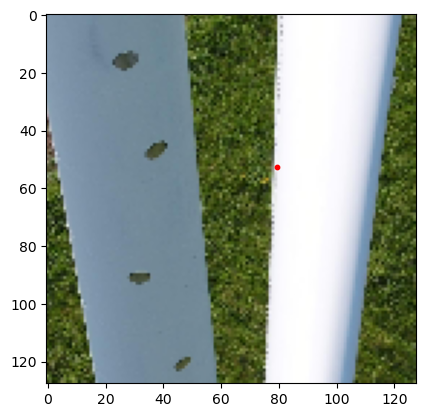

In [37]:
sub_image_test_original = OriginalDataset[1][10]
PlotCenterPoint(sub_image_test_original[0], sub_image_test_original[3])

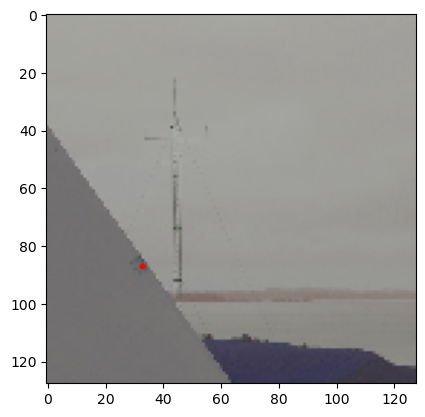

In [38]:
sub_image_test_augmented = AugmentedDataset[1][10]
PlotCenterPoint(sub_image_test_augmented[0], sub_image_test_augmented[3])

## Convolutional Neural Network

In [16]:
# Use DataLoader to handle batching and shuffling
batch_size = 128

TrainDatasetLoader = DataLoader(TrainDataset, batch_size = batch_size, shuffle = True)
ValDatasetLoader = DataLoader(ValDataset, batch_size = batch_size, shuffle = False)
TestDatasetLoader = DataLoader(TestDataset, batch_size = batch_size, shuffle = False)

In [17]:
# Create a class that creates a simple CNN
class ConvolutionalNeuralNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # Convolutional layers
        self.conv_3_8 = torch.nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 3, stride = 1, padding = 0)
        self.conv_8_16 = torch.nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 3, stride = 1, padding = 0)
        self.conv_16_20 = torch.nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 3, stride = 1, padding = 0)
        self.conv_20_26 = torch.nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 3, stride = 1, padding = 0)
        self.conv_26_32 = torch.nn.Conv2d(in_channels = 16, out_channels = 20, kernel_size = 3, stride = 1, padding = 0)
        self.conv_32_64 = torch.nn.Conv2d(in_channels = 20, out_channels = 20, kernel_size = 3, stride = 1, padding = 0)
        self.conv_64_128 = torch.nn.Conv2d(in_channels = 20, out_channels = 20, kernel_size = 3, stride = 1, padding = 0)
        self.conv_128_256 = torch.nn.Conv2d(in_channels = 20, out_channels = 20, kernel_size = 3, stride = 1, padding = 0)
        # Max pooling layers
        self.max_pool_2 = torch.nn.MaxPool2d(kernel_size = 2, stride = 1)
        self.max_pool_10 = torch.nn.MaxPool2d(kernel_size = 10, stride = 1)
        self.max_pool_15 = torch.nn.MaxPool2d(kernel_size = 15, stride = 1)
        self.max_pool_20 = torch.nn.MaxPool2d(kernel_size = 20, stride = 1)
        # Flatten layer
        self.flatten = torch.nn.Flatten()
        # Fully connected layers
        self.fc_255380_16384 = torch.nn.Linear(255380, 16384)
        self.fc_12168_4096 = torch.nn.Linear(12168, 4096)
        self.fc_4096_512 = torch.nn.Linear(4096, 512)
        self.fc_512_128 = torch.nn.Linear(512, 128)
        self.fc_16384_8192 = torch.nn.Linear(16384, 8192)
        self.fc_8192_4096 = torch.nn.Linear(8192, 4096)
        self.fc_6400_1024 = torch.nn.Linear(6400, 1024)
        self.fc_2048_1024 = torch.nn.Linear(2048, 1024)
        self.fc_1024_512 = torch.nn.Linear(1024, 512)
        self.fc_512_256 = torch.nn.Linear(512, 256)
        self.fc_256_128 = torch.nn.Linear(256, 128)
        self.fc_128_64 = torch.nn.Linear(128, 64)
        self.fc_64_32 = torch.nn.Linear(64, 32)
        self.output_layer = torch.nn.Linear(128, 6)
        # Activation functions
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
        self.tanh = torch.nn.Tanh()
        self.relu6 = torch.nn.ReLU6()
        self.leaky_relu = torch.nn.LeakyReLU()
        self.prelu = torch.nn.PReLU()
        # Dropout layers
        self.dropout_10 = torch.nn.Dropout(0.1)
        self.dropout_20 = torch.nn.Dropout(0.2)
        self.dropout_30 = torch.nn.Dropout(0.3)
        self.dropout_40 = torch.nn.Dropout(0.4)
        self.dropout_50 = torch.nn.Dropout(0.5)
        self.dropout_60 = torch.nn.Dropout(0.6)
        self.dropout_70 = torch.nn.Dropout(0.7)
        # Batch normalization layers
        self.batch_norm32768 = torch.nn.BatchNorm1d(32768)
        self.batch_norm16384 = torch.nn.BatchNorm1d(16384)
        self.batch_norm8192 = torch.nn.BatchNorm1d(8192)
        self.batch_norm4096 = torch.nn.BatchNorm1d(4096)
        self.batch_norm2048 = torch.nn.BatchNorm1d(2048)
        self.batch_norm1024 = torch.nn.BatchNorm1d(1024)
        self.batch_norm512 = torch.nn.BatchNorm1d(512)
        self.batch_norm256 = torch.nn.BatchNorm1d(256)
        self.batch_norm128 = torch.nn.BatchNorm1d(128)
        self.batch_norm64 = torch.nn.BatchNorm1d(64)
        self.batch_norm32 = torch.nn.BatchNorm1d(32)

    def forward(self, x):
        # Convolutional layers
        x = self.max_pool_2(self.relu(self.conv_3_8(x)))
        x = self.max_pool_2(self.relu(self.conv_8_16(x)))
        x = self.max_pool_2(self.relu(self.conv_16_20(x)))
        x = self.max_pool_2(self.relu(self.conv_20_26(x)))
        x = self.max_pool_2(self.relu(self.conv_26_32(x)))
        x = self.max_pool_2(self.relu(self.conv_32_64(x)))
        x = self.max_pool_2(self.relu(self.conv_64_128(x)))
        x = self.max_pool_2(self.relu(self.conv_128_256(x)))
        # Flatten layer
        x = self.flatten(x)
        # Fully connected layers
        # 12500 = 25 * 25 * 20 (25x25 is the size of the image after the last max pooling layer... I think)
        x = self.relu(self.batch_norm1024(self.fc_6400_1024(x)))
        x = self.relu(self.batch_norm512(self.fc_1024_512(x)))
        x = self.relu(self.batch_norm256(self.fc_512_256(x)))
        x = self.relu(self.batch_norm128(self.fc_256_128(x)))
        x = self.output_layer(x)

        return x

In [18]:
def train(model, train_loader, optimizer, loss_func, epochs, device, **kwargs):

    num_epochs = kwargs.get('num_epochs', epochs)
    loss_fn = kwargs.get('loss_fn', loss_func)
    device = kwargs.get('device', device)

    train_loss_hist, train_acc_hist = [], []

    # Add this line to create a plot
    plt.figure(figsize=(10, 5))
    plt.title('Training Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')

        print('Training phase...')
        model.train()
        train_loss = 0.
        total = 0.
        correct = 0.
        pbar = tqdm(enumerate(train_loader), total = len(train_loader))

        for batch_idx, (data, target) in pbar:
            data = data.permute(0, 3, 1, 2).to(device, dtype=torch.float32)
            target = target.to(device)
            model.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

            pbar.set_description(f'Loss = {loss:.4f}  |  Accuracy = {100 * correct / total:.2f}% | Batch ID = {batch_idx + 1} ')

        train_loss /= len(train_loader)
        train_accuracy = 100 * correct / total
        print(f'Training Cross-Entropy Loss = {train_loss:.4f}')
        print(f'Training Accuracy = {train_accuracy:.2f}%')
        print()

        train_loss_hist.append(train_loss)
        train_acc_hist.append(train_accuracy)

        # Add this line to update the plot
        plt.plot(range(1, epoch + 2), train_loss_hist)

    # Add this line to show the legend and display the plot
    plt.legend()
    plt.show()

    print(f"Cross-Entropy on training set:  {train_loss_hist[-1]:.4f}")
    print(f"Accuracy on training set:       {train_acc_hist[-1]:.2f}%")

    return train_loss_hist, train_acc_hist


def set_device(device_type='cuda'):
    if device_type == 'cuda' and torch.cuda.is_available():
        device = torch.device('cuda')
    elif device_type == 'mps' and torch.backends.mps.is_available():
        device = torch.device('mps')
    else:
        device = torch.device('cpu')
    print('Device:', device)
    return device


def set_device2():
    if torch.cuda.is_available():
        device = torch.device('cuda')

    elif torch.backends.mps.is_available():
        device = torch.device('mps')

    else:
        device = torch.device('cpu')
    print('Device:', device)

    return device

In [41]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 128 * 128, 512)
        self.fc2 = nn.Linear(512, 6)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 128 * 128)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
# Initialize the network, loss function, and optimizer
device = set_device()
#model = ConvolutionalNeuralNetwork().to(device)
model = SimpleCNN().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [19]:
# Initialize the network, loss function, and optimizer
device = set_device2()
model = ConvolutionalNeuralNetwork().to(device)
#model = SimpleCNN().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

Device: mps


Epoch 1/8
Training phase...


  0%|          | 0/72 [00:00<?, ?it/s]


RuntimeError: linear(): input and weight.T shapes cannot be multiplied (128x216320 and 6400x1024)

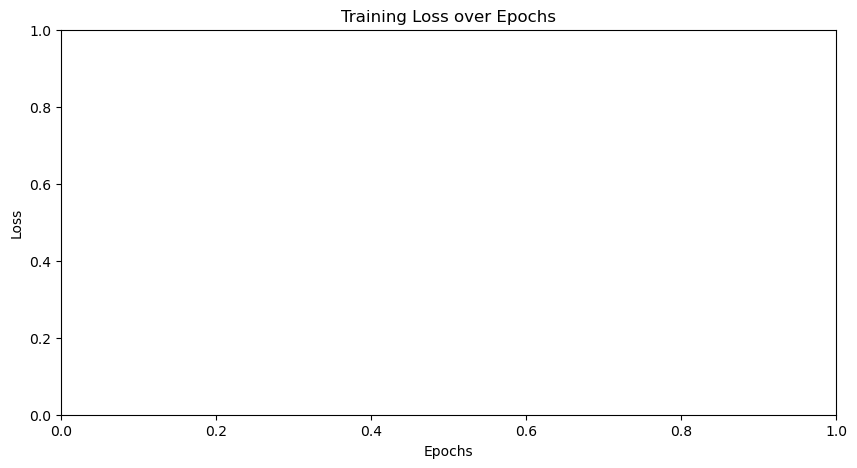

In [20]:
train_loss_hist, train_acc_hist = train(model, TrainDatasetLoader, optimizer, criterion, epochs = 8, device = device)

In [27]:
# Save the model
torch.save(model.state_dict(), 'model.pth')

In [28]:
# Load the model "model.pth"
model_load = ConvolutionalNeuralNetwork().to(device)
model_load.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

In [21]:
def evaluate(model, val_loader, loss_func, device):
    model.eval()
    val_loss = 0.
    total = 0.
    correct = 0.

    with torch.no_grad():
        for data, target in tqdm(val_loader):
            data = data.to(device)
            target = target.to(device)
            data = images.permute(0, 3, 1, 2)
            output = model(data)
            loss = loss_func(output, target)
            val_loss += loss.item()

            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total
    print(f'Validation Cross-Entropy Loss = {val_loss:.4f}')
    print(f'Validation Accuracy = {val_accuracy:.2f}%')
    print()

    return val_loss, val_accuracy

In [22]:
def test(model, test_loader, loss_func, device):

    model.eval()

    correct = 0
    total = 0
    test_loss = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            images = images.permute(0, 3, 1, 2)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            test_loss += loss_func(outputs, labels).item()

    test_loss /= len(test_loader)
    test_acc = 100 * correct / total

    return test_loss, test_acc

In [31]:
# Agora, avalie o modelo no conjunto de validação
val_loss, val_accuracy = test(model, ValDatasetLoader, criterion, device)

# Faça o que desejar com os resultados, como imprimir ou salvar
print(f'Final Validation Cross-Entropy Loss = {val_loss:.4f}')
print(f'Final Validation Accuracy = {val_accuracy:.2f}%')

Final Validation Cross-Entropy Loss = 0.9708
Final Validation Accuracy = 64.86%


In [29]:
# Agora, avalie o modelo no conjunto de validação
test_loss, test_accuracy = test(model, TestDatasetLoader, criterion, device)

# Faça o que desejar com os resultados, como imprimir ou salvar
print(f'Test Cross-Entropy Loss = {test_loss:.4f}')
print(f'Test Accuracy = {test_accuracy:.2f}%')

Test Cross-Entropy Loss = 1.4874
Test Accuracy = 60.00%


In [30]:
#Para considerar se quisermos aplicar o Tensorboard
from torch.utils.tensorboard import SummaryWriter


writer = SummaryWriter()


for epoch in range(epochs):
    for batch in TrainDatasetLoader:
            #adicionar treino aqui

    val_loss, val_accuracy = evaluate(model, ValDatasetLoader, criterion, device)
    

    writer.add_scalar('Loss/Train', train_loss, epoch)
    writer.add_scalar('Accuracy/Train', train_accuracy, epoch)
    writer.add_scalar('Loss/Validation', val_loss, epoch)
    writer.add_scalar('Accuracy/Validation', val_accuracy, epoch)


writer.close()


IndentationError: expected an indented block after 'for' statement on line 9 (1656437107.py, line 12)